In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsa.ts_utils import * 
from scripts.python.tsa.utsmodel import * 
from scripts.python.tsa.mtsmodel import * 
from scripts.python.tsa.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

## Load and Merge

In [2]:
vu = (pd.read_csv(os.getcwd() + "/data/tourism/vanuatu/intermediate/vu_monthly_visitor.csv")
        .drop("Unnamed: 0", axis=1))
vu["date"] = [str((int(y))) + "-" + str((int(m))) for y, m in zip(vu["Year"], vu["month"])]
vu["date"] = pd.to_datetime(vu["date"])
vu = (vu[vu.date >= "2004-01-01"].reset_index().drop("index", axis=1))

In [3]:
oceania_ci = (pd.read_csv(os.getcwd() + "/data/tourism/oceania_covid_stringency.csv")
              .drop("Unnamed: 0", axis=1))
oceania_ci["date"] = pd.to_datetime(oceania_ci["date"] )
oceania_ci.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [4]:
vu = (vu.merge(oceania_ci[["date", "stringency_index"]], how="left", on="date")
        .rename({"stringency_index": "covid"}, axis=1)
        .fillna(0))
vu.head(5)

,Year,Month,Australia,New Zealand,New Caledonia,Other PIC,Europe,North America,Japan,China,Other Countries,Total,fileyear,Not Stated,month,date,covid
0,2004.0,Jan,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,1.0,2004-01-01,0.0
1,2004.0,Feb,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,2.0,2004-02-01,0.0
2,2004.0,Mar,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,3.0,2004-03-01,0.0
3,2004.0,Apr,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,4.0,2004-04-01,0.0
4,2004.0,May,2076.0,491.0,588.0,121.0,228.0,149.0,61.0,0.0,78.0,3792.0,2005.0,0.0,5.0,2004-05-01,0.0


In [5]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_vanuatu.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
vu = (vu.merge(gt[["date", "vanuatu travel"]], how="left", on="date")
      .rename({"vanuatu travel": "vanuatu_travel"}, axis=1))
vu.head(5)

,Year,Month,Australia,New Zealand,New Caledonia,Other PIC,Europe,North America,Japan,China,Other Countries,Total,fileyear,Not Stated,month,date,covid,vanuatu_travel
0,2004.0,Jan,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,1.0,2004-01-01,0.0,2.453441
1,2004.0,Feb,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,2.0,2004-02-01,0.0,0.000000
2,2004.0,Mar,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,3.0,2004-03-01,0.0,0.000000
3,2004.0,Apr,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,4.0,2004-04-01,0.0,1.694580
4,2004.0,May,2076.0,491.0,588.0,121.0,228.0,149.0,61.0,0.0,78.0,3792.0,2005.0,0.0,5.0,2004-05-01,0.0,2.683400


## SARMIAX

In [6]:
naive_pred = naive_method(vu["Total"])
mean_pred = mean_method(vu["Total"])
snaive_pred = seasonal_naive_method(vu["Total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(vu["Total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,SMAPE
naive,2.928048e+06,1711.153898,1297.563063,20.615464
mean,1.128143e+07,3358.783399,2629.835549,47.787290
seasonal naive,8.494972e+06,2914.613524,1575.457399,34.656886


In [7]:
display(get_adf_df(vu, ["Total"]))
display(get_adf_df(vu[["Total"]].diff().dropna(), ["Total"]))

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-2.512493,0.112464,13.0,209.0,-3.462032,-2.875471,-2.574195


,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-3.211147,0.019348,12.0,209.0,-3.462032,-2.875471,-2.574195


In [8]:
vs = SARIMAXPipeline(data=vu, y_var="Total", exog_var=["covid", "vanuatu_travel"],
                     transform_method="scaledlogit", training_ratio=0.95)
vs.transform()
vs.stepwise_search()

TypeError: __init__() missing 1 required positional argument: 'country'

In [9]:
# Set parameter range
p, d, q = range(0, 3), [1], range(0, 3)
P, D, Q, s = range(0, 3), [1], range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
vs_msres = vs.manual_search(all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:658.31
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:585.51
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:580.98
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:634.75
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:582.37
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:579.95
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:611.32
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:581.04
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:581.48
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:628.36
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:554.55
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:549.82
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:599.95
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:551.16
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:549.65
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:576.41
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:549.78
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:551.33
Tried out SARIMAX(0, 1, 2)x(

In [10]:
vs_msres.sort(key=lambda x: x[1])
vs_models = []
vs_sw = vs.stepwise_model
vs_models.append(pm.ARIMA(
    vs_sw["order"], vs_sw["seasonal_order"],  exog=vs.exog[:vs.training_size]))


for res in vs_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=vs.exog[:vs.training_size])
    vs_models.append(model)

In [11]:
from pmdarima import model_selection 
cv = model_selection.SlidingWindowForecastCV(window_size=12, step=6, h=12)
for mod in vs_models:
    model_cv_scores = model_selection.cross_val_score(
        mod, vs.transformed_y[:vs.training_size], vs.exog[:vs.training_size], scoring="smape", verbose=2)
    model_avg_error = np.average(model_cv_scores)
    print(model_avg_error)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] fold=121 ........................................................
[CV] fold=122 ........................................................
[CV] fold=123 ........................................................
[CV] fold=124 ........................................................
[CV] fold=125 ........................................................
[CV] fold=126 ........................................................
[CV] fold=127 ........................................................
[CV] fold=128 ........................................................
[CV] fold=129 ........................................................
[CV] f

[CV] fold=91 .........................................................
[CV] fold=92 .........................................................
[CV] fold=93 .........................................................
[CV] fold=94 .........................................................
[CV] fold=95 .........................................................
[CV] fold=96 .........................................................
[CV] fold=97 .........................................................
[CV] fold=98 .........................................................
[CV] fold=99 .........................................................
[CV] fold=100 ........................................................
[CV] fold=101 ........................................................
[CV] fold=102 ........................................................
[CV] fold=103 ........................................................
[CV] fold=104 ........................................................
[CV] f

[CV] fold=66 .........................................................
[CV] fold=67 .........................................................
[CV] fold=68 .........................................................
[CV] fold=69 .........................................................
[CV] fold=70 .........................................................
[CV] fold=71 .........................................................
[CV] fold=72 .........................................................
[CV] fold=73 .........................................................
[CV] fold=74 .........................................................
[CV] fold=75 .........................................................
[CV] fold=76 .........................................................
[CV] fold=77 .........................................................
[CV] fold=78 .........................................................
[CV] fold=79 .........................................................
[CV] f

[CV] fold=41 .........................................................
[CV] fold=42 .........................................................
[CV] fold=43 .........................................................
[CV] fold=44 .........................................................
[CV] fold=45 .........................................................
[CV] fold=46 .........................................................
[CV] fold=47 .........................................................
[CV] fold=48 .........................................................
[CV] fold=49 .........................................................
[CV] fold=50 .........................................................
[CV] fold=51 .........................................................
[CV] fold=52 .........................................................
[CV] fold=53 .........................................................
[CV] fold=54 .........................................................
[CV] f

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] f

[CV] fold=132 ........................................................
[CV] fold=133 ........................................................
[CV] fold=134 ........................................................
[CV] fold=135 ........................................................
[CV] fold=136 ........................................................
[CV] fold=137 ........................................................
[CV] fold=138 ........................................................
[CV] fold=139 ........................................................
[CV] fold=140 ........................................................
61.82340235746375
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ...............................................

[CV] fold=107 ........................................................
[CV] fold=108 ........................................................
[CV] fold=109 ........................................................
[CV] fold=110 ........................................................
[CV] fold=111 ........................................................
[CV] fold=112 ........................................................
[CV] fold=113 ........................................................
[CV] fold=114 ........................................................
[CV] fold=115 ........................................................
[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] f

In [12]:
best_vs = vs_msres[4][0]
best_vs_mod = vs.get_prediction_df(
    best_vs, 12, vs.exog[-vs.test_size:])
lower = vu["Total"].min() - 1
upper = vu["Total"].max() + 1

for col_idx, col in enumerate(best_vs_mod.columns):
    for row_idx, _ in enumerate(best_vs_mod[col]):
        best_vs_mod.iloc[row_idx, col_idx] = vs.inverse_scaledlogit(
            best_vs_mod.iloc[row_idx, col_idx], upper, lower)

In [13]:
best_vs_mod = pd.concat([vu[["date", "Total"]], best_vs_mod], axis=1)
best_vs_mod.head(20)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2004-01-01,4492.0,6751.093662,NaN,-1.000000,NaN,NaN
1,2004-02-01,3488.0,4350.138086,NaN,-1.000000,NaN,NaN
2,2004-03-01,4014.0,3488.000444,NaN,-1.000000,NaN,NaN
3,2004-04-01,3955.0,4107.703971,NaN,-1.000000,NaN,NaN
4,2004-05-01,3792.0,4009.081770,NaN,-1.000000,NaN,NaN
5,2004-06-01,4373.0,3767.082420,NaN,-1.000000,NaN,NaN
6,2004-07-01,6116.0,4340.133156,NaN,-1.000000,NaN,NaN
7,2004-08-01,5741.0,6010.243713,NaN,-1.000000,NaN,NaN
8,2004-09-01,7146.0,6048.710367,NaN,-1.000000,NaN,NaN
9,2004-10-01,6915.0,6835.948063,NaN,-1.000000,NaN,NaN


In [14]:
pred_series = best_vs_mod["train_pred"].fillna(0) + best_vs_mod["test_pred"].fillna(0)
sl_eval = pd.DataFrame(calculate_evaluation(vu["Total"], pred_series), index=["scaled logit"])
sl_eval

,MSE,RMSE,MAE,MAPE
scaled logit,1.127502e+06,1061.838778,743.325708,inf


### No-Scaled

training size : 211, testing size : 12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3651.310, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3729.387, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3569.384, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3635.303, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3727.389, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3723.062, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3552.534, Time=0.60 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3561.202, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3551.046, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3640.561, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3553.008, Time=0.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3591.490, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3574.633,

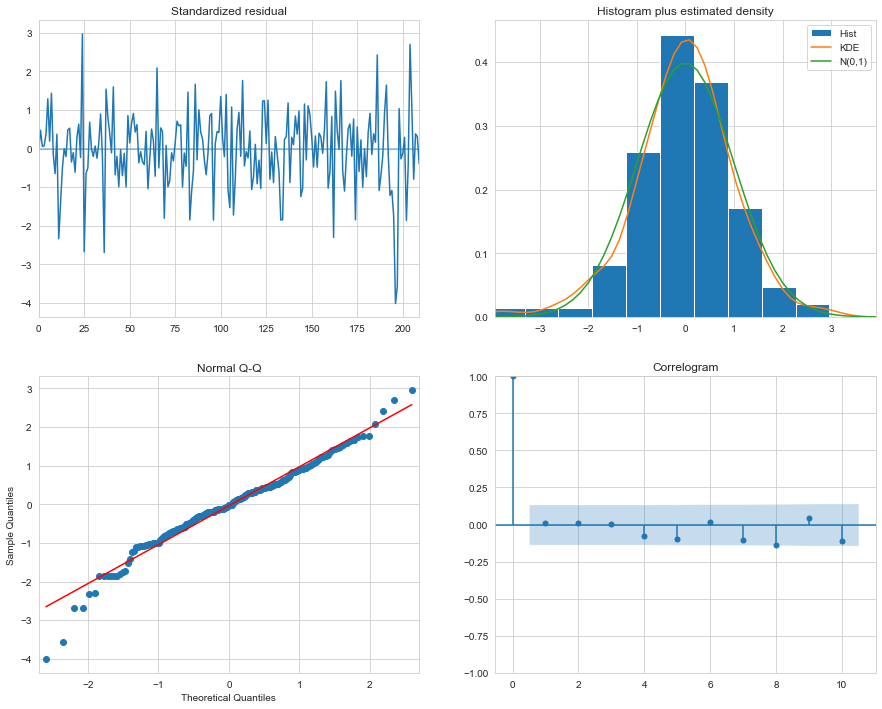

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:3408.59
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:3367.51
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:3366.71
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:3381.83
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:3364.85
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:3368.0
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:3377.9
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:3366.4
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:3369.86
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:3378.58
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:3339.05
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:3340.45
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:3347.6
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:3340.18
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:3344.44
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:3344.99
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:3342.38
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:3346.76
Tried out SARI

In [15]:
vo = SARIMAXPipeline(data=vu, y_var="Total", exog_var=["covid", "vanuatu_travel"],
                     transform_method=None, training_ratio=0.95)
vo.transform()
vo.stepwise_search()
vo_msres = vo.manual_search(all_param)

In [16]:
vo_msres.sort(key=lambda x: x[1])
vo_models = []
vo_sw = vo.stepwise_model
vo_models.append(pm.ARIMA(
    vo_sw["order"], vo_sw["seasonal_order"],  exog=vo.exog[:vo.training_size]))


for res in vo_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=vo.exog[:vo.training_size])
    vo_models.append(model)

In [17]:
for mod in vo_models:
    model_cv_scores = model_selection.cross_val_score(
        mod, vo.transformed_y[:vo.training_size], vo.exog[:vo.training_size], scoring="smape", verbose=2)
    model_avg_error = np.average(model_cv_scores)
    print(model_avg_error)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] fold=121 ........................................................
[CV] fold=122 ........................................................
[CV] fold=123 ........................................................
[CV] fold=124 ........................................................
[CV] fold=125 ........................................................
[CV] fold=126 ........................................................
[CV] fold=127 ........................................................
[CV] fold=128 ........................................................
[CV] fold=129 ........................................................
[CV] f

[CV] fold=91 .........................................................
[CV] fold=92 .........................................................
[CV] fold=93 .........................................................
[CV] fold=94 .........................................................
[CV] fold=95 .........................................................
[CV] fold=96 .........................................................
[CV] fold=97 .........................................................
[CV] fold=98 .........................................................
[CV] fold=99 .........................................................
[CV] fold=100 ........................................................
[CV] fold=101 ........................................................
[CV] fold=102 ........................................................
[CV] fold=103 ........................................................
[CV] fold=104 ........................................................
[CV] f

[CV] fold=66 .........................................................
[CV] fold=67 .........................................................
[CV] fold=68 .........................................................
[CV] fold=69 .........................................................
[CV] fold=70 .........................................................
[CV] fold=71 .........................................................
[CV] fold=72 .........................................................
[CV] fold=73 .........................................................
[CV] fold=74 .........................................................
[CV] fold=75 .........................................................
[CV] fold=76 .........................................................
[CV] fold=77 .........................................................
[CV] fold=78 .........................................................
[CV] fold=79 .........................................................
[CV] f

[CV] fold=41 .........................................................
[CV] fold=42 .........................................................
[CV] fold=43 .........................................................
[CV] fold=44 .........................................................
[CV] fold=45 .........................................................
[CV] fold=46 .........................................................
[CV] fold=47 .........................................................
[CV] fold=48 .........................................................
[CV] fold=49 .........................................................
[CV] fold=50 .........................................................
[CV] fold=51 .........................................................
[CV] fold=52 .........................................................
[CV] fold=53 .........................................................
[CV] fold=54 .........................................................
[CV] f

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] f

[CV] fold=132 ........................................................
[CV] fold=133 ........................................................
[CV] fold=134 ........................................................
[CV] fold=135 ........................................................
[CV] fold=136 ........................................................
[CV] fold=137 ........................................................
[CV] fold=138 ........................................................
[CV] fold=139 ........................................................
[CV] fold=140 ........................................................
31.112789146160605
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..............................................

[CV] fold=107 ........................................................
[CV] fold=108 ........................................................
[CV] fold=109 ........................................................
[CV] fold=110 ........................................................
[CV] fold=111 ........................................................
[CV] fold=112 ........................................................
[CV] fold=113 ........................................................
[CV] fold=114 ........................................................
[CV] fold=115 ........................................................
[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] f

In [18]:
best_original = vo_msres[1][0]
original_mod = vo.get_prediction_df(best_original, steps=vo.test_size, exog=vo.exog[-vo.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([vu[["date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2004-01-01,4492.0,-466.706762,1923.255964,-4236.219183,3302.805660,NaN
1,2004-02-01,3488.0,4143.683620,1612.137649,983.951889,7303.415351,NaN
2,2004-03-01,4014.0,3625.676049,1598.664270,492.351656,6759.000442,NaN
3,2004-04-01,3955.0,3601.577381,1597.772357,470.001106,6733.153656,NaN
4,2004-05-01,3792.0,3680.541782,1597.712498,549.082827,6812.000737,NaN


In [19]:
org_pred = original_mod["train_pred"].fillna(0) + original_mod["test_pred"].fillna(0)
org_eval = pd.DataFrame(calculate_evaluation(vu["Total"], org_pred), index=["original"])
org_eval

,MSE,RMSE,MAE,MAPE
original,1.546558e+06,1243.606901,888.323368,inf


## VAR

In [9]:
vu_merged = (pd.read_csv(os.getcwd() + "/data/tourism/vanuatu/intermediate/vanuatu_merged.csv")
             .drop("Unnamed: 0", axis=1))
vu_merged["date"] = pd.to_datetime(vu_merged["date"])
vu_merged = (vu_merged.merge(gt[["date", "vanuatu travel"]], how="left", on="date")
             .merge(oceania_ci[["date", "stringency_index"]], how="left", on="date"))
vu_merged.columns = [col.lower().replace(" ", "_") for col in vu_merged.columns]
vu_merged.head(5)

,year,australia,new_zealand,new_caledonia,other_pic,europe,north_america,japan,china,other_countries,total,not_stated,month,date,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,vanuatu_travel,stringency_index
0,2019.0,5251.0,767.0,1786.0,481.0,523.0,229.0,61.0,284.0,166.0,9548.0,0.0,1.0,2019-01-01,123.0,123.0,18568.0,18568.0,0.611803,NaN
1,2019.0,2740.0,503.0,923.0,526.0,456.0,152.0,57.0,326.0,152.0,5835.0,0.0,2.0,2019-02-01,94.0,97.0,13680.0,14190.0,0.547938,NaN
2,2019.0,3864.0,611.0,949.0,411.0,413.0,209.0,71.0,331.0,167.0,7026.0,0.0,3.0,2019-03-01,101.0,101.0,14774.0,14774.0,0.656599,NaN
3,2019.0,5195.0,1010.0,1164.0,507.0,731.0,180.0,102.0,294.0,262.0,9445.0,0.0,4.0,2019-04-01,112.0,112.0,17071.0,17071.0,0.764806,NaN
4,2019.0,3919.0,868.0,1139.0,552.0,806.0,294.0,60.0,425.0,296.0,8359.0,0.0,5.0,2019-05-01,111.0,111.0,16764.0,16764.0,0.651209,NaN


In [10]:
vu_diff = vu_merged[["total", "seats_arrivals_intl"]].diff().dropna()
vu_merged = vu_merged.fillna(0)

In [11]:
select_cols = ["total", "seats_arrivals_intl"]
varma_res = varma_search(vu_diff, select_cols, vu_merged[["stringency_index", "vanuatu_travel"]][1:])

NameError: name 'varma_search' is not defined

In [23]:
varma_res_df = pd.DataFrame(varma_res).sort_values(by="result")

In [24]:
from statsmodels.tsa.api import VARMAX
varma = VARMAX(endog=vu_diff[["total", "seats_arrivals_intl"]],
               exog=vu_merged[["stringency_index"]][1:], order=(1, 1), tr="t")
varma_res = varma.fit(disp=False)
varma_res.summary()

Dep. Variable:,"['total', 'seats_arrivals_intl']",No. Observations:,42
Model:,"VARMAX(1,1)",Log Likelihood,-736.587
,+ intercept,AIC,1503.175
Date:,"Mon, 24 Apr 2023",BIC,1529.240
Time:,16:50:01,HQIC,1512.729
Sample:,0,,
,- 42,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.02, 0.01",Jarque-Bera (JB):,"6.28, 41.63"
Prob(Q):,"0.89, 0.91",Prob(JB):,"0.04, 0.00"
Heteroskedasticity (H):,"0.28, 0.99",Skew:,"0.12, 1.13"


In [25]:
varma_pred = varma_res.get_prediction().summary_frame()
varma_pred_series = varma_pred["mean"].cumsum() + vu_merged["total"][0]
pd.DataFrame(calculate_evaluation(vu_merged["total"], varma_pred_series), index=["VARMA"])

,MSE,RMSE,MAE,MAPE
VARMA,1.998597e+07,4470.566611,3935.088274,inf


In [26]:
var_mean = mean_method(vu_merged["total"])
var_naive = naive_method(vu_merged["total"])


var_metrics = pd.DataFrame()
for idx, pred in enumerate([var_mean, var_naive]):
    df = pd.DataFrame(calculate_evaluation(vu_merged["total"], pred), index=[idx])
    var_metrics = pd.concat([var_metrics, df], axis=0)
    
var_metrics.index = ["mean", "naive"]
var_metrics

,MSE,RMSE,MAE,MAPE
mean,2.273834e+07,4768.473803,4264.861006,inf
naive,2.446383e+06,1564.091833,808.452381,inf


## Ratio

In [12]:
vu_merged["ratio"] = vu_merged["total"]/vu_merged["seats_arrivals_intl"]

adj_ratio = []
for idx, ratio in enumerate(vu_merged["ratio"]):
    if ratio < 1:
        adj_ratio.append(ratio)
    else:
        ratio = ((vu_merged["ratio"][idx-1] + vu_merged["ratio"][idx+1]))/2
        adj_ratio.append(ratio)
        
vu_merged["adj_ratio"] = adj_ratio

In [21]:
vu_merged["seats_arrivals_intl"]

0     18568.0
1     13680.0
2     14774.0
3     17071.0
4     16764.0
5     16088.0
6     15992.0
7     15904.0
8     15406.0
9     15599.0
10    15236.0
11    16708.0
12    17066.0
13     8986.0
14     9632.0
15      316.0
16        0.0
17      136.0
18      544.0
19     1088.0
20     2834.0
21     2195.0
22     2034.0
23     2556.0
24     3060.0
25     3374.0
26     3062.0
27     3488.0
28     3078.0
29     3474.0
30     3406.0
31     3100.0
32     2620.0
33     4220.0
34     4050.0
35     3910.0
36     1870.0
37     2720.0
38     2350.0
39      920.0
40        0.0
41       70.0
42    11684.0
Name: seats_arrivals_intl, dtype: float64

In [13]:
get_adf_df(vu_merged, ["adj_ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
adj_ratio,-1.485634,0.540606,1.0,41.0,-3.600983,-2.935135,-2.605963


In [29]:
temp = (vu_merged[["ratio", "adj_ratio", "stringency_index", "date", "vanuatu_travel"]]
        .reset_index()
        .drop("index", axis=1)
        .fillna(0))
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
temp.head(5)

,ratio,adj_ratio,stringency_index,date,vanuatu_travel,covid,quarter
0,0.514218,0.514218,0.0,2019-01-01,0.611803,False,1
1,0.426535,0.426535,0.0,2019-02-01,0.547938,False,1
2,0.475565,0.475565,0.0,2019-03-01,0.656599,False,1
3,0.553277,0.553277,0.0,2019-04-01,0.764806,False,2
4,0.498628,0.498628,0.0,2019-05-01,0.651209,False,2


In [30]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="adj_ratio ~ covid * stringency_index + C(quarter) + vanuatu_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              adj_ratio   R-squared:                       0.952
Model:                            WLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     99.84
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           3.25e-21
Time:                        16:50:01   Log-Likelihood:                 55.431
No. Observations:                  43   AIC:                            -94.86
Df Residuals:                      35   BIC:                            -80.77
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.4359      0.061      7.143      0.000       0.312       0.560
covid[T.True]                     -0.4923      0.074     -6.694      0.000      -0.642      -0.343
C(quarter)[T.2]                    0.0141      0.032      0.441      0.662      -0.051       0.079
C(quarter)[T.3]                    0.1112      0.033      3.331      0.002       0.043       0.179
C(quarter)[T.4]                    0.0924      0.037      2.515      0.017       0.018       0.167
stringency_index                  -0.0052      0.002     -2.727      0.010      -0.009      -0.001
covid[T.True]:stringency_index     0.0038      0.002      1.591      0.121      -0.001       0.009
vanuatu_travel                     0.2478      0.080      3.079      0.004       0.084       0.411
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.175
Skew:                           0.136   Prob(JB):                        0.916
Kurtosis:                       3.152   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
ratio_pred = res.get_prediction().summary_frame()
vu_merged["pred"] = (ratio_pred["mean"] * vu_merged["seats_arrivals_intl"])
pd.DataFrame(calculate_evaluation(vu_merged["total"], vu_merged["pred"]), index=["Ratio"])

,MSE,RMSE,MAE,MAPE
Ratio,642113.393395,801.319782,497.354972,inf
